RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier


In [11]:
# Load datasets
df_train = pd.read_json('dataset/for_modeling/test.json')
df_val = pd.read_json('dataset/for_modeling/validation.json')
df_test = pd.read_json('dataset/for_modeling/test.json')

In [12]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Projects practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)

# Features
selected_features = ['num_commits', 'project_age_days', 'num_contributors', 
                     'num_issues', 'num_pull', 'num_opening_issue', 'project_size(kB)', 
                     'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers']

# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train['Generic policy']
X_val, y_val = df_val[selected_features], df_val['Generic policy']
X_test, y_test = df_test[selected_features], df_test['Generic policy']

In [13]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Random forest Classification

In [14]:
# Train Random forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None)
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.73
Validation Report:
              precision    recall  f1-score   support

           0       0.33      0.07      0.12        14
           1       0.75      0.95      0.84        42

    accuracy                           0.73        56
   macro avg       0.54      0.51      0.48        56
weighted avg       0.65      0.73      0.66        56

Test Accuracy: 1.00
Test Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        19

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



100%|██████████| 28/28 [00:02<00:00, 11.06it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

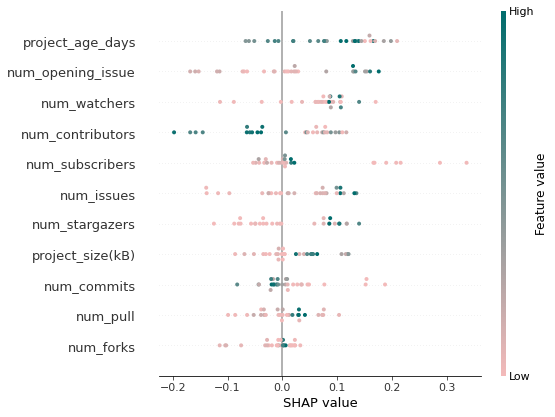

In [15]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

XGBoost Classification

In [16]:
xg_clf = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.1, objective='binary:logistic', use_label_encoder=False)
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.75
Validation Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.75      1.00      0.86        42

    accuracy                           0.75        56
   macro avg       0.38      0.50      0.43        56
weighted avg       0.56      0.75      0.64        56

Test Accuracy: 0.68
Test Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.68      1.00      0.81        19

    accuracy                           0.68        28
   macro avg       0.34      0.50      0.40        28
weighted avg       0.46      0.68      0.55        28



C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [14:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classifica

Text(0.5, 32.10000000000005, 'SHAP value')

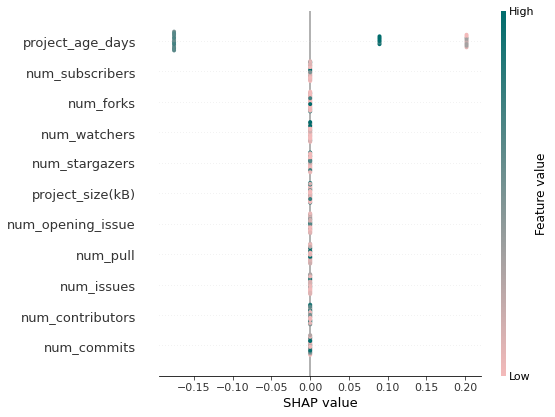

In [17]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

NN MLPClassifier

In [18]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic', max_iter=500)
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.75
Validation Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.75      1.00      0.86        42

    accuracy                           0.75        56
   macro avg       0.38      0.50      0.43        56
weighted avg       0.56      0.75      0.64        56

Test Accuracy: 0.71
Test Report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.70      1.00      0.83        19

    accuracy                           0.71        28
   macro avg       0.85      0.56      0.51        28
weighted avg       0.80      0.71      0.62        28



C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classific